In [1]:
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
import tarfile
import numpy as np
from IPython.display import clear_output
import time
import shutil
import os
import random
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, RandomCrop, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomWidth, RandomHeight
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras.applications import EfficientNetB5

plt.style.use("dark_background")

In [2]:
def download_and_untar_dataset(url, filename):
    urllib.request.urlretrieve(
        url=url,
        filename=filename
    )

    tar = tarfile.open(filename)
    tar.extractall()
    tar.close()

url = open("D:/workspace/private/coding_test/buzzni/dataset_url.txt", mode="r").readline()
filename = "computer_vision_task.tar.bz2"
download_and_untar_dataset(url=url, filename=filename)

In [35]:
seed = 77
img_size = 456
batch_size = 32
def prepare_dataset(dir, subset, validation_split):
    print(f"Loaded images from '{dir}'")
    ds = image_dataset_from_directory(
        directory=dir,
        validation_split=validation_split,
        subset=subset,
        seed=seed, 
        shuffle=True,
        image_size=(img_size, img_size),
        batch_size=batch_size)
    return ds

dir = "computer_vision_task/train"
validation_split=0.2
ds_tr = prepare_dataset(dir=dir, 
    subset="training", 
    validation_split=validation_split)
ds_val = prepare_dataset(dir=dir, 
    subset="validation", 
    validation_split=validation_split)

classes = ds_tr.class_names
n_classes = len(classes)

ds_tr = ds_tr.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Loaded images from 'computer_vision_task/train'
Found 500 files belonging to 50 classes.
Using 400 files for training.
Loaded images from 'computer_vision_task/train'
Found 500 files belonging to 50 classes.
Using 100 files for validation.


# Modeling
- Reference #1: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- 주어진 Data set에서 Labeled images는 500장밖에 되지 않으므로 이것만 가지고 모델을 학습시켜서는 높은 Performance를 기대할 수 없겠다고 판단했습니다. 이에 Reference #1을 참고하여 Two-stage transfer learning을 시도했습니다. (Baseline model로는 EfficientNet을 선택했으며 1000개의 ImageNet classes로 Pre-trained된 Weights를 사용했습니다.) 그 과정은 다음과 같습니다.
    - Transferred layers를 Freeze하고 그것을 제외한 나머지 Layers (`GlobalAveragePooling2D()`, `BatchNormalization()`, `Dropout()`, `Dense()`)만을 Unfreeze한 상태로 Model을 학습시킵니다.
    - Transferred layers 중에서 Top 20개를 다시 Unfreeze한 상태로 Model을 학습시킵니다. 이때 Unfreeze하는 Layers의 수 (20개)는 몇 번의 실험을 거쳐 Model의 Performance가 가장 높게 나온 것으로 선택했습니다. 이것을 더 큰 숫자로 정할 경우 Overfitting이 발생한다고 판단했습니다. Learning rate는 이전 학습 때보다 작은 것을 선택해야한다고 하여 그대로 따랐습니다.
- 이렇게 학습시킨 Model은 Validaton set에 대해 70% 정도의 Top-1 accuracy를 기록했습니다.

In [36]:
def build_model(data_augmentation):
    inputs = Input(shape=(img_size, img_size, 3))

    z = data_augmentation(inputs)
    effi_net = EfficientNetB5(include_top=False, 
        input_tensor=z, 
        weights="imagenet", 
        drop_connect_rate=0.5)

    effi_net.trainable = False

    z = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(effi_net.output)
    z = BatchNormalization()(z)
    z = Dropout(rate=0.5, name="Dropout")(z)
    outputs = Dense(units=n_classes, activation="softmax", name="Dense")(z)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-2), 
        loss="sparse_categorical_crossentropy", 
        metrics=["acc", metrics.SparseTopKCategoricalAccuracy()])
    return model


data_aug = Sequential([
    RandomRotation(factor=0.1, fill_mode="constant", fill_value=255), 
    RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant", fill_value=255),  
    RandomFlip("horizontal"), 
    RandomZoom(height_factor=0.1, fill_mode="constant", fill_value=255), 
    RandomWidth(factor=0.1),
    RandomHeight(factor=0.1), 
    RandomCrop(height=img_size, width=img_size)
    ])
model = build_model(data_augmentation=data_aug)

def model_fit(model, dataset_tr, dataset_val, epochs):
    fit = model.fit(dataset_tr, 
    validation_data=dataset_val, 
    epochs=epochs, 
    verbose=2)
    return fit

hist = model_fit(model=model, 
    dataset_tr=ds_tr, 
    dataset_val=ds_val, 
    epochs=4)


def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

unfreeze_model(model)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["acc", metrics.SparseTopKCategoricalAccuracy()])

hist = model_fit(model=model, 
    dataset_tr=ds_tr, 
    dataset_val=ds_val, 
    epochs=8)

Epoch 1/4
13/13 - 32s - loss: 4.7882 - acc: 0.2325 - sparse_top_k_categorical_accuracy: 0.5275 - val_loss: 2.1148 - val_acc: 0.4700 - val_sparse_top_k_categorical_accuracy: 0.8400 - 32s/epoch - 2s/step
Epoch 2/4
13/13 - 13s - loss: 1.7349 - acc: 0.6675 - sparse_top_k_categorical_accuracy: 0.9450 - val_loss: 1.4282 - val_acc: 0.6100 - val_sparse_top_k_categorical_accuracy: 0.9500 - 13s/epoch - 985ms/step
Epoch 3/4
13/13 - 13s - loss: 1.2359 - acc: 0.7550 - sparse_top_k_categorical_accuracy: 0.9550 - val_loss: 1.4052 - val_acc: 0.6000 - val_sparse_top_k_categorical_accuracy: 0.9200 - 13s/epoch - 992ms/step
Epoch 4/4
13/13 - 13s - loss: 0.6870 - acc: 0.8400 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 1.2604 - val_acc: 0.6600 - val_sparse_top_k_categorical_accuracy: 0.9200 - 13s/epoch - 997ms/step
Epoch 1/8
13/13 - 30s - loss: 0.5254 - acc: 0.8900 - sparse_top_k_categorical_accuracy: 0.9925 - val_loss: 1.1858 - val_acc: 0.6600 - val_sparse_top_k_categorical_accuracy: 0.9200 - 3

# Semi-Supervised Learning
- Reference #2: https://blog.francium.tech/semi-supervised-learning-with-pseudo-labeling-de65988bb3b3
- 앞서 "computer_vision_task/train" 폴더에 있는 500장 Labeled images로 Model을 학습시켰습니다. 이제 "computer_vision_task/test" 폴더에 있는 Unlabeled images를 활용해보도록 하겠습니다. 방법은 다음과 같습니다.
    - 우선 Unlabeled image 각각의 파일명을 수정합니다. 그 이유는 추후 Pseudo-label에 따라 Unlabeled images의 경로가 변경될 것이기 때문에 같은 폴더 내에 동일한 파일명이 중복되지 않도록 하기 위함입니다. 또한 이렇게 파일명을 변경한 Unlabeled images를 편의를 위해 하나의 폴더 "computer_vision_task/unlabeled"로 옮깁니다. 이를 구현한 함수가 `rename_and_move_images()`입니다.
    - 이제 "computer_vision_task/unlabeled" 폴더에 있는 Unlabeled images를 750장씩 Iterate 하며 이들의 Labels를 Model을 사용하여 Predict합니다. 이를 Pseudo-label이라고 부르며, Pseudo-label을 Ground truth처럼 생각하여 Model을 학습시키는 데 사용합니다. 구체적으로는 500장의 Labeled images 중 절반을 Validation set으로 삼고 나머지 절반을 750장의 Pseudo-labeled images와 합쳐 이것으로 Model을 학습시킵니다. 
    - 이렇게 학습된 Model을 다음 750장의 Unlabeled images의 Labels를 Predict하는 데 다시 사용합니다. "computer_vision_task/pseudo-label-0" ~ "computer_vision_task/pseudo-label-4" 폴더는 각 750장의 Pseudo-labeld images를 따로 저장하는 데 사용됩니다. 이 과정을 구현한 함수가 `train_with_unlabeled_data()`입니다.

## 개선할 점
- Reference #3: https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af
- 기대했던 바와 다르게 Semi-supervised learning을 진행할수록 Validation set에 대한 Loss는 계속 증가했습니다.
- Reference #3의 내용을 살펴보니, 적절한 값 α에 대해 (Labeled loss + α*Unlabeled loss)를 사용해 Model을 학습시켜야 한다고 합니다. 시간이 부족해 이 부분은 구현하지 못했습니다.

In [38]:
def rename_and_move_images(dir, unlabeled_dir):
    # `unlabeled_dir` 폴더가 존재하지 않으면 생성합니다.
    if not os.path.exists(unlabeled_dir):
        os.makedirs(unlabeled_dir)

    for sub_dir in os.listdir(dir):
        for file_name in os.listdir(f"{dir}/{sub_dir}"):
            old_name = f"{dir}/{sub_dir}/{file_name}"
            new_name = f"{dir}/{sub_dir}/{sub_dir}-{file_name}"
            if os.path.isfile(old_name) and "-" not in old_name:
                # 각각의 Image 파일명을 "X.jpg" 형식에서 "LABEL-X.jpg" 형식으로 바꿉니다.
                os.rename(old_name, new_name)

            src = old_name if "-" in old_name else new_name
            dest = f"{unlabeled_dir}/{src.split(f'{dir}/{sub_dir}/', 1)[-1]}"
            shutil.copy(src, dest)

unlabeled_dir = "computer_vision_task/unlabeled"
rename_and_move_images(dir="computer_vision_task/test", 
    unlabeled_dir=unlabeled_dir)

In [51]:
# for i in range(5):
#     shutil.rmtree(f"computer_vision_task/pseudo-label-{i}", ignore_errors=True)

dir = "computer_vision_task/train"
validation_split=0.5
ds_tr = prepare_dataset(dir=dir, 
    subset="training", 
    validation_split=validation_split)
ds_val = prepare_dataset(dir=dir, 
    subset="validation", 
    validation_split=validation_split)

def train_with_unlabeled_data(n_split):
    unlabeled_images = os.listdir(unlabeled_dir)
    random.shuffle(unlabeled_images)
    cut = len(unlabeled_images)//n_split + 1

    p_label_dir = "computer_vision_task/pseudo-label"

    k = 0
    for num, file_name in enumerate(tqdm(unlabeled_images)):
        src = f"{unlabeled_dir}/{file_name}"
        img = cv2.imread(src)
        img = cv2.resize(img, (img_size, img_size))
        
        data = img[None, :]
        model_out = model(data)
        p_label = np.argmax(model_out)

        tar_dir = f"{p_label_dir}-{k}/{p_label}"
        if not os.path.exists(tar_dir):
            os.makedirs(tar_dir)
        dest = f"{p_label_dir}-{k}/{p_label}/{file_name}"
        shutil.copy(src, dest)

        if (num + 1)%cut == 0:
            ds_p_label = prepare_dataset(dir=f"{p_label_dir}-{k}", 
                subset=None, 
                validation_split=None)
            
            model_fit(model=model, 
                dataset_tr=ds_tr.concatenate(ds_p_label), 
                dataset_val=ds_val, 
                epochs=3)

            k += 1

    ds_p_label = prepare_dataset(dir=f"{p_label_dir}-{k}", 
        subset=None, 
        validation_split=None)

    model_fit(model=model, 
        dataset_tr=ds_tr.concatenate(ds_p_label), 
        dataset_val=ds_val, 
        epochs=3)

train_with_unlabeled_data(n_split=5)

Loaded images from 'computer_vision_task/train'
Found 500 files belonging to 50 classes.
Using 250 files for training.
Loaded images from 'computer_vision_task/train'
Found 500 files belonging to 50 classes.
Using 250 files for validation.


  0%|          | 0/3748 [00:00<?, ?it/s]

Loaded images from 'computer_vision_task/pseudo-label-0'
Found 750 files belonging to 47 classes.
Epoch 1/3
32/32 - 39s - loss: 7.9712 - acc: 0.1940 - sparse_top_k_categorical_accuracy: 0.3740 - val_loss: 2.2008 - val_acc: 0.4480 - val_sparse_top_k_categorical_accuracy: 0.8200 - 39s/epoch - 1s/step
Epoch 2/3
32/32 - 40s - loss: 6.0914 - acc: 0.2400 - sparse_top_k_categorical_accuracy: 0.4780 - val_loss: 2.6491 - val_acc: 0.3640 - val_sparse_top_k_categorical_accuracy: 0.8160 - 40s/epoch - 1s/step
Epoch 3/3
32/32 - 40s - loss: 5.1942 - acc: 0.3100 - sparse_top_k_categorical_accuracy: 0.5580 - val_loss: 3.1528 - val_acc: 0.3880 - val_sparse_top_k_categorical_accuracy: 0.8080 - 40s/epoch - 1s/step
Loaded images from 'computer_vision_task/pseudo-label-1'
Found 750 files belonging to 48 classes.
Epoch 1/3
32/32 - 40s - loss: 7.0059 - acc: 0.1950 - sparse_top_k_categorical_accuracy: 0.4170 - val_loss: 2.3888 - val_acc: 0.4040 - val_sparse_top_k_categorical_accuracy: 0.8000 - 40s/epoch - 1s/s

# Evaluate Model
- Model이 내놓는 결과에 대해 최선에서 최악까지 순서를 매겨보면 다음과 같습니다.
    - (1) Model이 내놓은 Top-1 prediction이 Ground truth와 일치하는 경우
    - (2) Model이 내놓은 Top-k prediction 안에 Ground truth가 존재하는 경우
    - (3) Model이 내놓은 Top-k prediction 안에 Ground truth가 존재하지 않는 경우
- Top-1 accuracy의 경우 그 계산 방식은 쉽게 말해 (1)의 경우에만 1점을 부여하여, 전체 Prediction에 대한 Score를 더한 값을 전체 Images의 수로 나눠주는 것과 같습니다.
- (2)의 경우에도 (3)의 경우보다는 의미있는 Prediction을 한 것으로 보아 어떤 상수 penalty에 대해 (1 - penalty) 만큼의 Score를 부여하는 아이디어를 떠올리게 됐습니다.
- (3)의 경우에 부여하는 Score는 0입니다.
- 이를 구현한 함수 `evaluate_model()`의 코드는 다음과 같습니다.

In [50]:
ds_te = prepare_dataset(dir="computer_vision_task/test", 
    subset=None, 
    validation_split=None)

def evaluate_model(model, k, penalty):
    tot_score = 0
    for idx, (images, labels) in enumerate(tqdm(ds_te)):
        gt_batch = labels.numpy()[:, None]
        probs_batch = model(images)
        topn_batch = tf.argsort(probs_batch, direction="DESCENDING").numpy()

        ranks = np.where(topn_batch==gt_batch)[1]
        scores = np.where(ranks==0, 1, np.where(ranks <= k, 1 - penalty, 0))
        tot_score += np.sum(scores)

    return tot_score/len(os.listdir("computer_vision_task/test"))

acc = evaluate_model(model=model,
    k=5, 
    penalty=0.7)

print(f"The accuracy of the model is {round(acc, 1)}%")

Loaded images from 'computer_vision_task/test'
Found 3748 files belonging to 50 classes.


  0%|          | 0/118 [00:00<?, ?it/s]

The accuracy of the model is 23.3%


# Human-in-the-loop
- Model이 Top-1 prediction에 대해 확신을 갖지 못하는 경우, 해당 이미지를 데이터 전문가에게 배정하여 올바르게 Labeling을 할 필요가 있습니다.
- "확신을 갖지 못한다"의 기준으로서, Top-1 prediction에 대한 Probability가 상수 `threshold` 미만인 경우를 가정했습니다. 
- Test set에 존재하는 전체 이미지에 대해 Model이 확신을 갖지 못하는 경우에는 해당 이미지와 Top-k prediction을 출력하고 이 이미지에 대해 사람이 판단한 올바른 Label을 입력 받아 해당 이미지와 맵핑합니다. 반대로 Model이 확신을 갖는 경우에는 해당 이미지와 Top-1 prediction을 맵핑합니다.
- 이렇게 맵핑된 Label과 이미지를 Python Dictionary 형태로 저장하여 출력하는 함수 `correct_labels_dictionary()`의 코드는 다음과 같습니다.

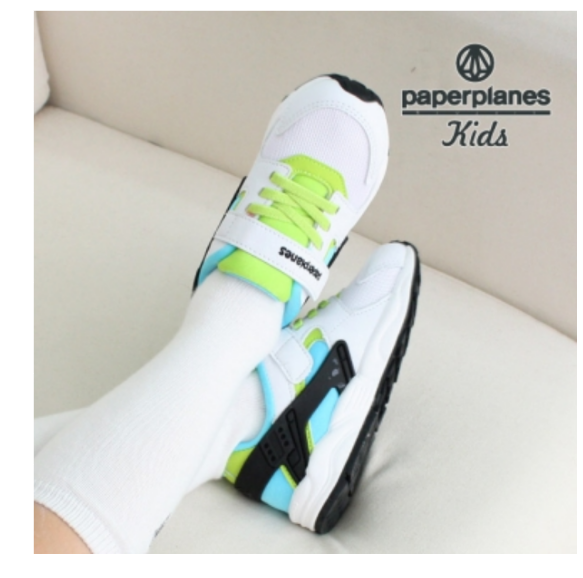

Top 5 predictions are;
	31
	38
	21
	16
	27
Please input correct label for this image:


In [ ]:
def correct_labels_dictionary(k, threshold):
    corr_labels = defaultdict(list)
    files = ds_te.file_paths
    for batch, (images, labels) in enumerate(tqdm(ds_te)):
        gt_batch = labels.numpy()[:, None]
        probs_batch = model(images)
        topn_batch = tf.argsort(probs_batch, direction="DESCENDING").numpy()
        probs_batch_sort = tf.sort(probs_batch, direction="DESCENDING").numpy()
        topk_batch = topn_batch[:, :k]
        for idx, (topk, top1_prob) in enumerate(zip(topk_batch, probs_batch_sort[-1])):
            if top1_prob < threshold:
                plt.figure(figsize=(10, 10))
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.show()
                print(f"Top {k} predictions are;")
                for i in range(k):
                    print(f"\t{topk[i]}")
                time.sleep(1)
                print("Please input correct label for this image:")
                label = int(input())
            else:
                label = labels[idx].numpy()
            corr_labels[label].append(files[batch_size*batch + idx])
            time.sleep(1)
            clear_output()
    return corr_labels

correct_labels_dictionary(k=5, threshold=0.8)